In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "cirrhosis"

In [2]:
library(caret)
library(LiblineaR)
library(kernlab)
library(randomForest)
library(MLeval)

BiocManager::install('ALDEx2')
library(ALDEx2)

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress



Attaching package: ‘kernlab’


The following object is masked from ‘package:purrr’:

    cross


The following object is masked from ‘package:ggplot2’:

    alpha


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: http://cran.rstudio.com/


Bioconductor version 3.12 (BiocManager 1.30.15), R 4.0.5 (2021-03-31)

Installing package(s) 'ALDEx2'

also installing the dependencies ‘GenomeInfoDbData’, ‘zlibbioc’, ‘GenomeInfoDb’, ‘XVector’, ‘MatrixGenerics’, ‘Biobase’, ‘

In [3]:
# returns vector of cluster ids for clusters with internal
# complete-linkage correlation of min.cor
"cluster.by.correlation" <- function(x, min.cor=.75){
#     library('fastcluster')
    cc <- cor(x,use='pairwise.complete.obs',method='pear')
    if(ncol(x) == 379) browser()
    cc <- as.dist(1-cc)
    hc <- hclust(cc)
    res <- cutree(hc,h=1-min.cor)
    names(res) <- colnames(x)
    return(res)
}

# returns vector of cluster ids for clusters with internal
# complete-linkage correlation of min.cor
#
# by default, chooses cluster reps as highest-variance member
# if select.rep.fcn=mean
"collapse.by.correlation" <- function(x, min.cor=.5, select.rep.fcn=c('var','mean','lowest.mean',
			'longest.name', 'shortest.name')[2],
        verbose=FALSE){
    if(verbose) cat('Clustering',ncol(x),'features...')
    gr <- cluster.by.correlation(x, min.cor=min.cor)
    if(verbose) cat('getting means...')
    if(select.rep.fcn == 'mean'){
        v <- apply(x,2,function(xx) mean(xx,na.rm=TRUE))
    } else if(select.rep.fcn == 'lowest.mean'){
        v <- apply(x,2,function(xx) -mean(xx,na.rm=TRUE))
    } else if(select.rep.fcn == 'longest.name'){
        v <- nchar(colnames(x))
    } else if(select.rep.fcn == 'shortest.name'){
        v <- -nchar(colnames(x))
    } else {
        v <- apply(x,2,function(xx) var(xx,use='complete.obs'))
    }
    if(verbose) cat('choosing reps...')
    reps <- sapply(split(1:ncol(x),gr),function(xx) xx[which.max(v[xx])])
    if(verbose)
        cat(sprintf('collapsed from %d to %d.\n',ncol(x), length(reps)))
    return(list(reps=reps, groups=gr))
}


[1] "rows: 130 columns: 8483"


,"NC_012781.1 Eubacterium rectale ATCC 33656, complete genome","NC_006347.1 Bacteroides fragilis YCH46 DNA, complete genome","NC_004663.1 Bacteroides thetaiotaomicron VPI-5482 chromosome, complete genome","NC_004337.2 Shigella flexneri 2a str. 301 chromosome, complete genome","NC_002695.1 Escherichia coli O157:H7 str. Sakai, complete genome","NC_000913.3 Escherichia coli str. K-12 substr. MG1655, complete genome","NC_000907.1 Haemophilus influenzae Rd KW20 chromosome, complete genome","NC_000896.1 Lactobacillus prophage phiadh, complete genome","NC_000872.1 Streptococcus phage Sfi21, complete genome","NC_000871.1 Streptococcus phage Sfi19, complete genome",⋯,"NZ_LN908984.1 Eggerthellaceae bacterium AT8 genome assembly Hugonella massiliensis, scaffold scaffold00007, whole genome shotgun sequence","NZ_LN908986.1 Eggerthellaceae bacterium AT8 genome assembly Hugonella massiliensis, scaffold scaffold00009, whole genome shotgun sequence","NZ_LN908985.1 Eggerthellaceae bacterium AT8 genome assembly Hugonella massiliensis, scaffold scaffold00008, whole genome shotgun sequence","NZ_LN912997.1 Ruminococcus sp. AT10 genome assembly Ruminococcus phoceensis, scaffold scaffold00001, whole genome shotgun sequence","NZ_LN912998.1 Ruminococcus sp. AT10 genome assembly Ruminococcus phoceensis, scaffold scaffold00002, whole genome shotgun sequence","NZ_LT629939.1 Phocea massiliensis strain Marseille-P2769, whole genome shotgun sequence","NZ_LT575468.1 Plesiomonas shigelloides strain NCTC10360 genome assembly, chromosome: 1","NZ_LT571436.1 Neisseria weaveri strain NCTC13585 genome assembly, chromosome: 1","NZ_LT603683.1 Bacillus glycinifermentans isolate BGLY genome assembly, chromosome: 1","NZ_LT630450.1 Desulfovibrio piger isolate DESPIGER1 genome assembly, chromosome: I"
LD.73,772362,985222,1132274,6791,5607,167766,76,0,0,0,⋯,0,0,0,0,0,494,2,0,0,21
LD.11,215106,132056,442525,45,44,765,4,0,0,0,⋯,0,0,0,0,0,2788,2,0,0,58
LD.26,762022,589642,109962,9093,6688,165958,4674,0,0,0,⋯,6,0,0,0,0,488,12,4,0,0
HD.61,271998,186254,267920,22,36,302,0,0,0,0,⋯,0,0,0,0,0,1750,0,0,0,22
LD.61,1156,137271,775077,3797,3624,72651,220,0,0,0,⋯,0,0,0,0,0,16,2,0,0,0
LD.77,31558,1202090,767396,2723,2723,44082,20723,0,0,0,⋯,0,0,0,16,0,400,345,0,0,0


,"NC_012781.1 Eubacterium rectale ATCC 33656, complete genome","NC_006347.1 Bacteroides fragilis YCH46 DNA, complete genome","NC_004663.1 Bacteroides thetaiotaomicron VPI-5482 chromosome, complete genome","NC_004337.2 Shigella flexneri 2a str. 301 chromosome, complete genome","NC_002695.1 Escherichia coli O157:H7 str. Sakai, complete genome","NC_000913.3 Escherichia coli str. K-12 substr. MG1655, complete genome","NC_000907.1 Haemophilus influenzae Rd KW20 chromosome, complete genome","NC_000896.1 Lactobacillus prophage phiadh, complete genome","NC_000872.1 Streptococcus phage Sfi21, complete genome","NC_000871.1 Streptococcus phage Sfi19, complete genome",⋯,"NZ_LN908984.1 Eggerthellaceae bacterium AT8 genome assembly Hugonella massiliensis, scaffold scaffold00007, whole genome shotgun sequence","NZ_LN908986.1 Eggerthellaceae bacterium AT8 genome assembly Hugonella massiliensis, scaffold scaffold00009, whole genome shotgun sequence","NZ_LN908985.1 Eggerthellaceae bacterium AT8 genome assembly Hugonella massiliensis, scaffold scaffold00008, whole genome shotgun sequence","NZ_LN912997.1 Ruminococcus sp. AT10 genome assembly Ruminococcus phoceensis, scaffold scaffold00001, whole genome shotgun sequence","NZ_LN912998.1 Ruminococcus sp. AT10 genome assembly Ruminococcus phoceensis, scaffold scaffold00002, whole genome shotgun sequence","NZ_LT629939.1 Phocea massiliensis strain Marseille-P2769, whole genome shotgun sequence","NZ_LT575468.1 Plesiomonas shigelloides strain NCTC10360 genome assembly, chromosome: 1","NZ_LT571436.1 Neisseria weaveri strain NCTC13585 genome assembly, chromosome: 1","NZ_LT603683.1 Bacillus glycinifermentans isolate BGLY genome assembly, chromosome: 1","NZ_LT630450.1 Desulfovibrio piger isolate DESPIGER1 genome assembly, chromosome: I"
LD.73,0.0546516704,0.069713461,0.080118734,4.805253e-04,3.967465e-04,1.187098e-02,5.377695e-06,0,0,0,⋯,0.000000e+00,0,0,0.000000e+00,0,3.495501e-05,1.415183e-07,0.000000e+00,0,1.485942e-06
LD.11,0.0078688638,0.004830784,0.016188154,1.646160e-06,1.609579e-06,2.798472e-05,1.463253e-07,0,0,0,⋯,0.000000e+00,0,0,0.000000e+00,0,1.019888e-04,7.316266e-08,0.000000e+00,0,2.121717e-06
LD.26,0.0652695615,0.050504677,0.009418588,7.788438e-04,5.728481e-04,1.421482e-02,4.003427e-04,0,0,0,⋯,5.139187e-07,0,0,0.000000e+00,0,4.179872e-05,1.027837e-06,3.426125e-07,0,0.000000e+00
HD.61,0.0287832287,0.019709672,0.028351689,2.328072e-06,3.809573e-06,3.195808e-05,0.000000e+00,0,0,0,⋯,0.000000e+00,0,0,0.000000e+00,0,1.851876e-04,0.000000e+00,0.000000e+00,0,2.328072e-06
LD.61,0.0001614375,0.019170139,0.108240879,5.302578e-04,5.060980e-04,1.014584e-02,3.072339e-05,0,0,0,⋯,0.000000e+00,0,0,0.000000e+00,0,2.234428e-06,2.793036e-07,0.000000e+00,0,0.000000e+00
LD.77,0.0015918394,0.060635473,0.038708765,1.373528e-04,1.373528e-04,2.223571e-03,1.045304e-03,0,0,0,⋯,0.000000e+00,0,0,8.070673e-07,0,2.017668e-05,1.740239e-05,0.000000e+00,0,0.000000e+00


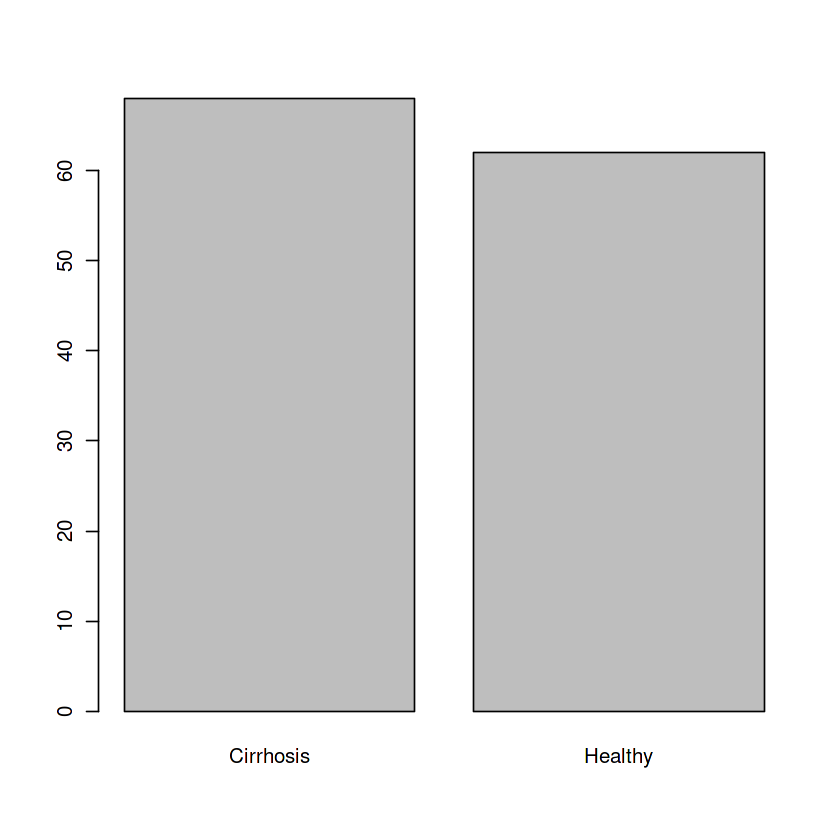

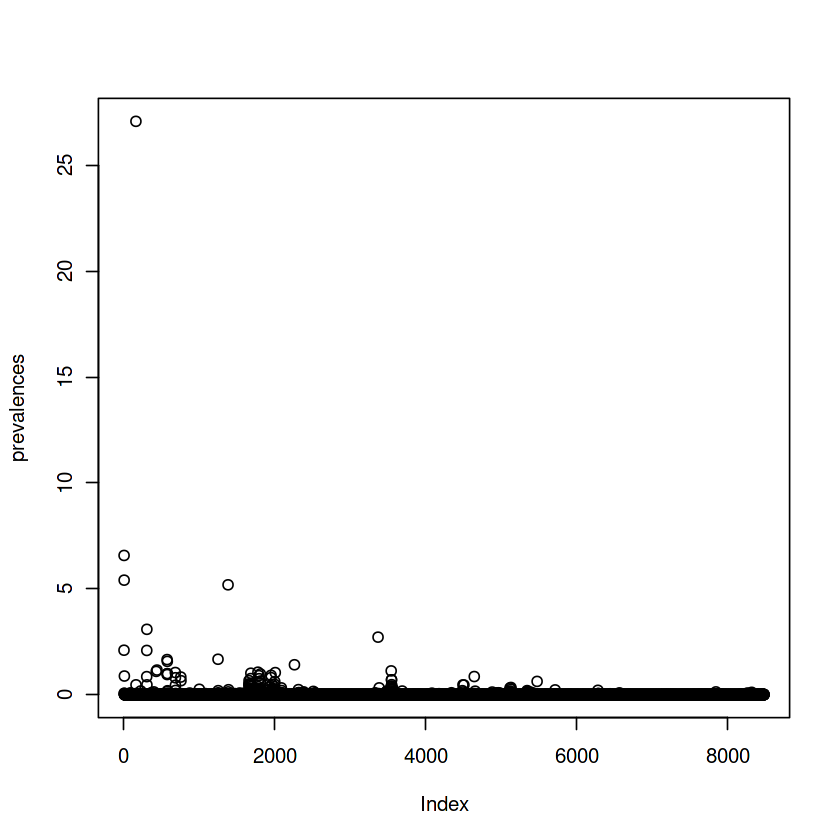

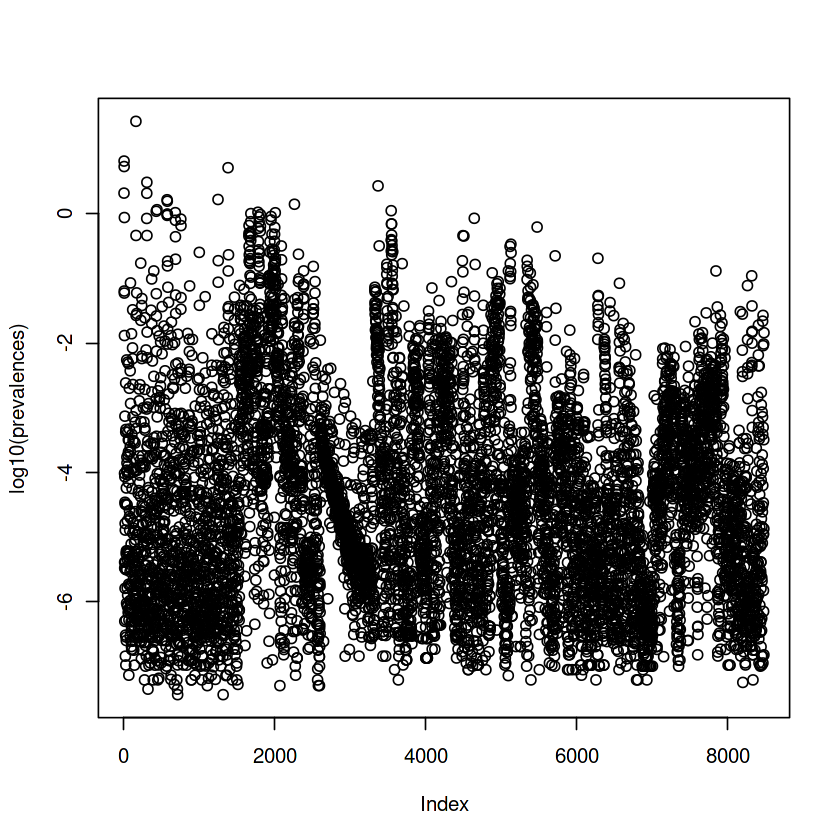

[1]  130 4511

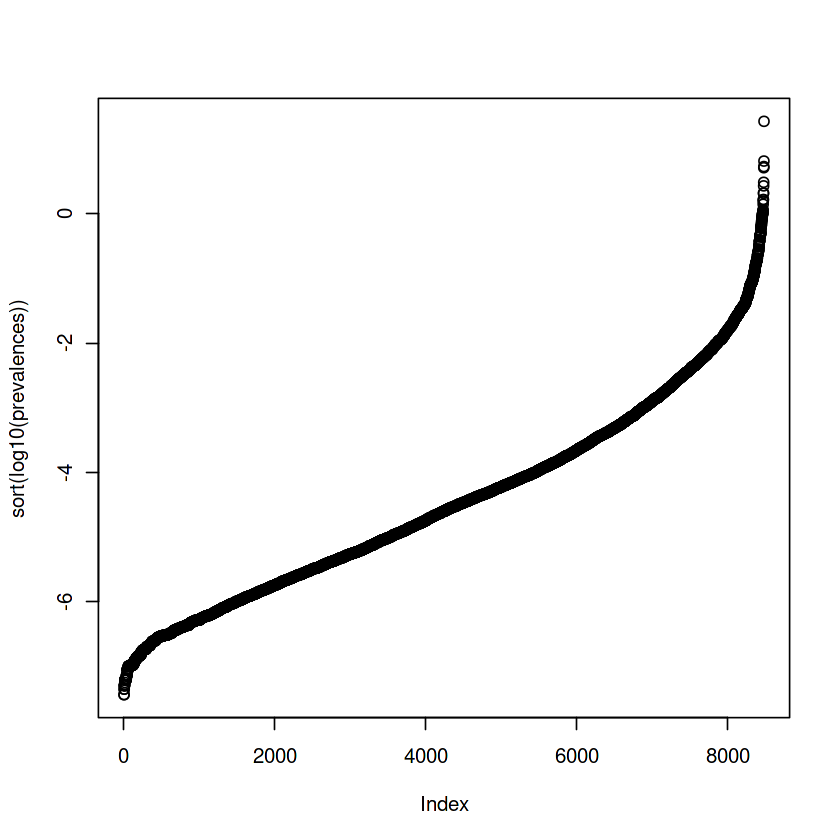

In [4]:
task_file = '/kaggle/input/cirrhosis/task-healthy-cirrhosis.txt'

#read the file with information on predictors
task = read.table(task_file, sep="\t", comment="", row=1, head=T, quote="", check.names=F, colClasses="character")

#change the predictor variable to factor
task$Var = as.factor(make.names(task$Var))




#check the distribution of the samples between classes
plot(task$Var)

otu_table_file = "/kaggle/input/cirrhosis/otutable.txt"

#read data table
otu = read.table(otu_table_file,sep="\t", comment="", row=1, head=T, quote="", check.names=F)

#transpose the table so now we have objects (patients) in rows and features (OTUs) in columns
otu = t(otu)

#Check dimensions of the otu table
print(paste("rows:",dim(otu)[1],"columns:",dim(otu)[2],sep = " "))
head(otu)

#normalize otu table by total sum normalization
otu = sweep(otu,1, rowSums(otu), '/')
head(otu)

#Check how the data looks like in terms of OTU prevalences
prevalences = apply(otu, 2, function(x) sum(x))
plot(prevalences)

plot(log10(prevalences))

plot(sort(log10(prevalences)))

prevalances = apply(otu, 2, function(x) mean(x>0))

#select only those outs with prevalence above a certain treshold threshol
otu = otu[, prevalances >= 0.1]

#check how many OTUs were left in the table after filtering by prevalence
dim(otu)



In [5]:
#filter features by correlation similarity
#find cluster of features with  internal complete-linkage correlation of 0.95
#choose cluster representation as a highest-variance member (with the hightest mean)

#code source from https://github.com/knights-lab/MLRepo
ret <- collapse.by.correlation(otu, .95 , verbose=TRUE)

otu = otu[, ret$reps]

#check how many OTUs were left in the table after filtering by prevalence by correlation similarity
dim(otu)

Clustering 4511 features...getting means...choosing reps...collapsed from 4511 to 2977.


[1]  130 2977

[1]  105 2977

Regularized Logistic Regression 

 105 samples
2977 predictors
   2 classes: 'Cirrhosis', 'Healthy' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 84, 84, 84, 84, 84, 84, ... 
Resampling results across tuning parameters:

  cost  loss       epsilon  Accuracy   Kappa       
  0.5   L1         0.001    0.4761905   0.000000000
  0.5   L1         0.010    0.4761905   0.000000000
  0.5   L1         0.100    0.4761905   0.000000000
  0.5   L2_dual    0.001    0.5174603  -0.011949686
  0.5   L2_dual    0.010    0.5142857  -0.018212419
  0.5   L2_dual    0.100    0.5174603  -0.011949686
  0.5   L2_primal  0.001    0.5174603  -0.011949686
  0.5   L2_primal  0.010    0.5174603  -0.011949686
  0.5   L2_primal  0.100    0.5174603  -0.011949686
  1.0   L1         0.001    0.5238095   0.000000000
  1.0   L1         0.010    0.5238095   0.000000000
  1.0   L1         0.100    0.5238095   0.000000000
  1.0   L2_dual    0.001    0.5142857  -0.011211

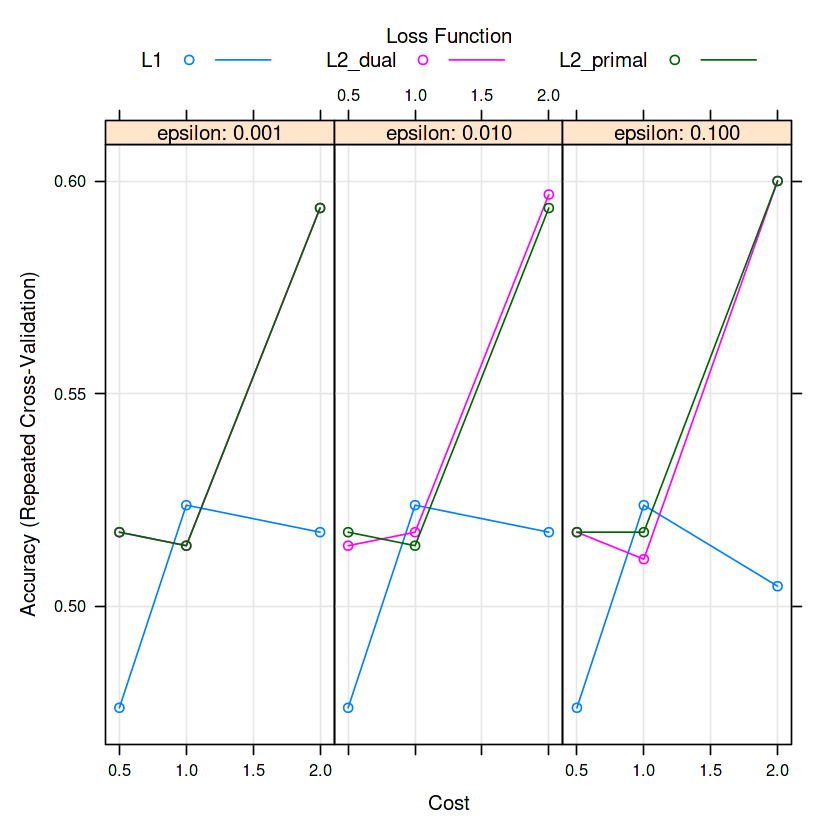

In [6]:
require(caret)

# Let's create train and held-out dataset. 
#We will train our model on the train dataset and we will check the prediction on the  held out dataset

train_indexes = createDataPartition(task$Var, p=0.8, list=FALSE)

otu_train = otu[train_indexes, ]
task_train_var = task$Var[train_indexes]

otu_held_out = otu[-train_indexes, ]
task_held_out = task$Var[-train_indexes]

dim(otu_train)

#parameters for nested k-fold cross validations
folds = 5  #10-fold CV
nests = 3  #5 nested

#let's start with accuracy
fitControl <- trainControl(method = "repeatedcv", 
                           number = folds,   #number of folds in k-fold CV
                           repeats = nests,  #number of outer repetitions in nested k-fold CV
                           classProbs = TRUE,
                           savePredictions = TRUE)


set.seed(825)
regLog_model <- train(x = otu_train, y = task_train_var,
               method = "regLogistic", 
               trControl = fitControl)

print(regLog_model)

plot(regLog_model)

Regularized Logistic Regression 

 105 samples
2977 predictors
   2 classes: 'Cirrhosis', 'Healthy' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 84, 84, 84, 84, 84, 84, ... 
Resampling results across tuning parameters:

  cost  loss       epsilon  ROC        Sens       Spec       
  0.5   L1         0.001    0.5000000  0.0000000  1.000000000
  0.5   L1         0.010    0.5000000  0.0000000  1.000000000
  0.5   L1         0.100    0.5000000  0.0000000  1.000000000
  0.5   L2_dual    0.001    0.6290909  0.9818182  0.006666667
  0.5   L2_dual    0.010    0.6290909  0.9757576  0.006666667
  0.5   L2_dual    0.100    0.6290909  0.9818182  0.006666667
  0.5   L2_primal  0.001    0.6290909  0.9818182  0.006666667
  0.5   L2_primal  0.010    0.6290909  0.9818182  0.006666667
  0.5   L2_primal  0.100    0.6193939  0.9818182  0.006666667
  1.0   L1         0.001    0.4739394  1.0000000  0.000000000
  1.0   L1         0.010    0.4739394  1.0

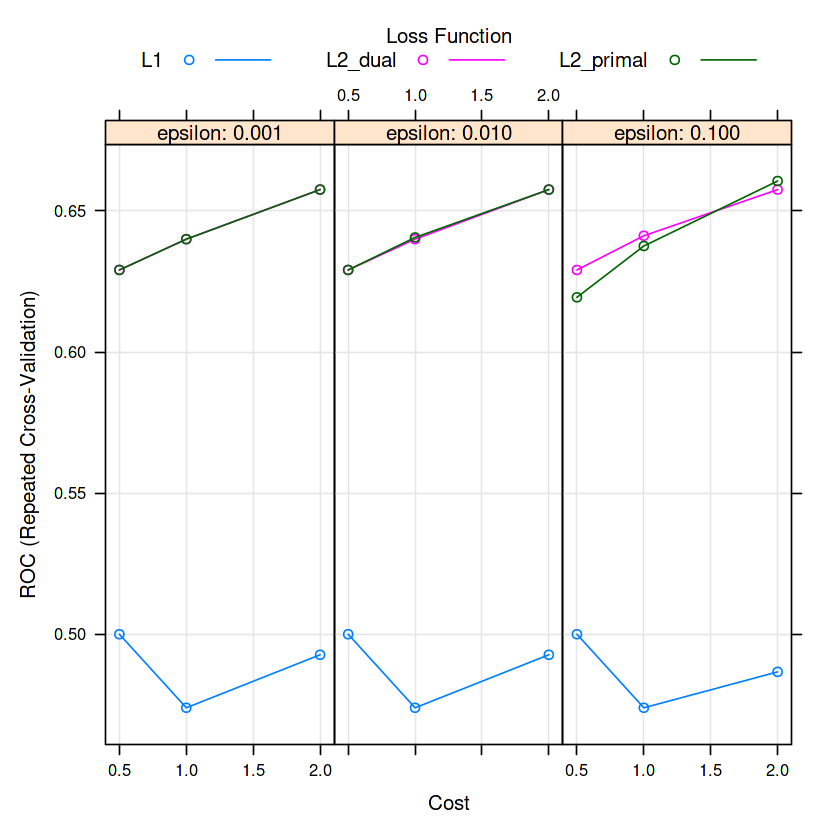

In [7]:
fitControl <- trainControl(method = "repeatedcv", 
                           number = folds,   #number of folds in k-fold CV
                           repeats = nests,  #number of outer repetitions in nested k-fold CV
                           classProbs = TRUE,
                           savePredictions = TRUE,
                           summaryFunction = twoClassSummary)

set.seed(825)
regLog_model <- train(x = otu_train, y = task_train_var,
               method = "regLogistic", 
               trControl = fitControl,
               metric = "ROC")

print(regLog_model)
#Sens = TP / (TP+FN)  
#Spec = TN / (TN+FP)

plot(regLog_model)

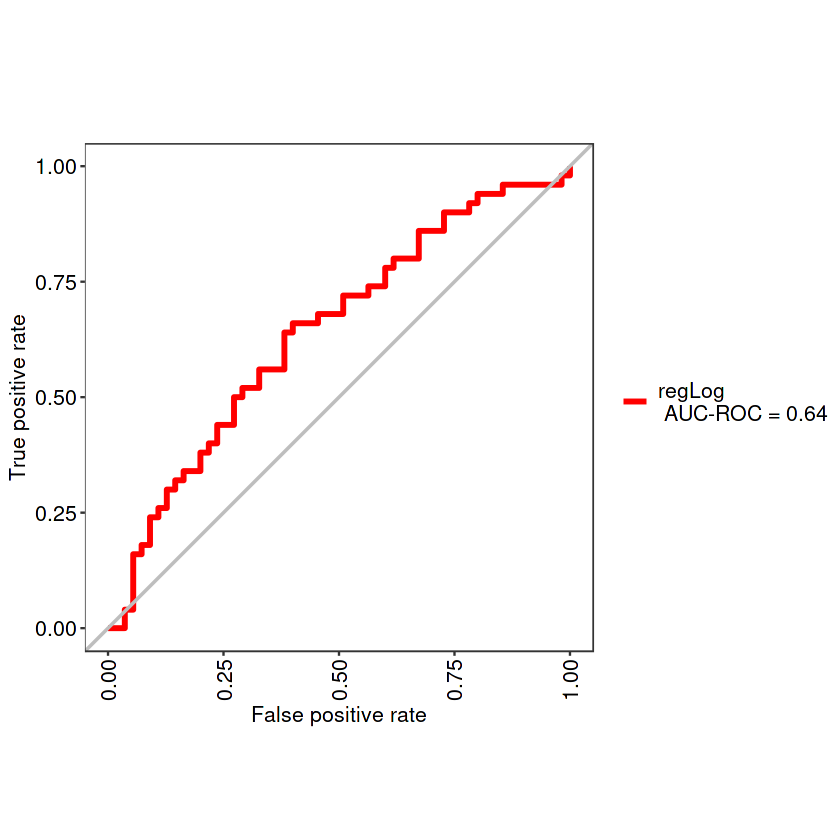

In [8]:
#load the library that will let us easily plot ROC curves
library(MLeval)

rec = evalm(list(regLog_model), gnames = c('regLog'), plots = c("r"), silent = TRUE)

In [9]:
pred = predict(regLog_model, otu_held_out)

confusionMatrix(table(task_held_out, pred))

Confusion Matrix and Statistics

             pred
task_held_out Cirrhosis Healthy
    Cirrhosis        10       3
    Healthy           9       3
                                         
               Accuracy : 0.52           
                 95% CI : (0.3131, 0.722)
    No Information Rate : 0.76           
    P-Value [Acc > NIR] : 0.9977         
                                         
                  Kappa : 0.0196         
                                         
 Mcnemar's Test P-Value : 0.1489         
                                         
            Sensitivity : 0.5263         
            Specificity : 0.5000         
         Pos Pred Value : 0.7692         
         Neg Pred Value : 0.2500         
             Prevalence : 0.7600         
         Detection Rate : 0.4000         
   Detection Prevalence : 0.5200         
      Balanced Accuracy : 0.5132         
                                         
       'Positive' Class : Cirrhosis      
             

## SVM

Support Vector Machines with Radial Basis Function Kernel 

 105 samples
2977 predictors
   2 classes: 'Cirrhosis', 'Healthy' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 84, 84, 84, 84, 84, 84, ... 
Resampling results across tuning parameters:

  C     ROC        Sens       Spec     
  0.25  0.7372727  0.8121212  0.4800000
  0.50  0.7372727  0.7939394  0.5266667
  1.00  0.7554545  0.9454545  0.3066667

Tuning parameter 'sigma' was held constant at a value of 0.0002169391
ROC was used to select the optimal model using the largest value.
The final values used for the model were sigma = 0.0002169391 and C = 1.


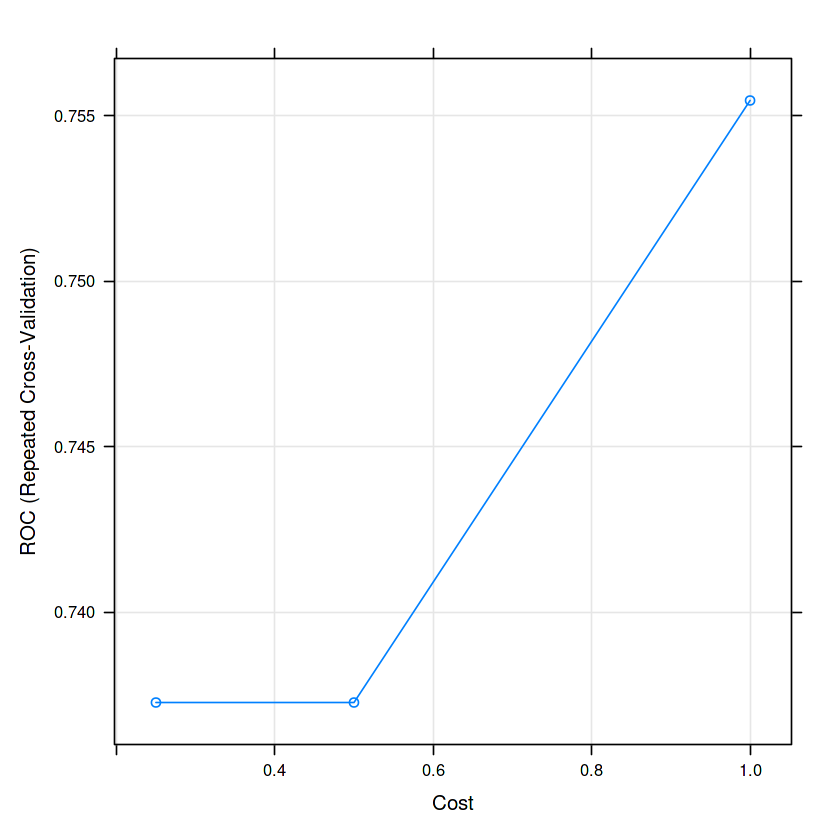

In [10]:
require(kernlab)

fitControl <- trainControl(method = "repeatedcv", 
                           number = folds,   #number of folds in k-fold CV
                           repeats = nests,  #number of outer repetitions in nested k-fold CV
                           classProbs = TRUE,
                           savePredictions = TRUE,
                           summaryFunction = twoClassSummary)


set.seed(825)
svm_model <- train(x = otu_train, y = task_train_var,
               method = "svmRadial",  
               trControl = fitControl,
               metric = "ROC")

print(svm_model)

plot(svm_model)

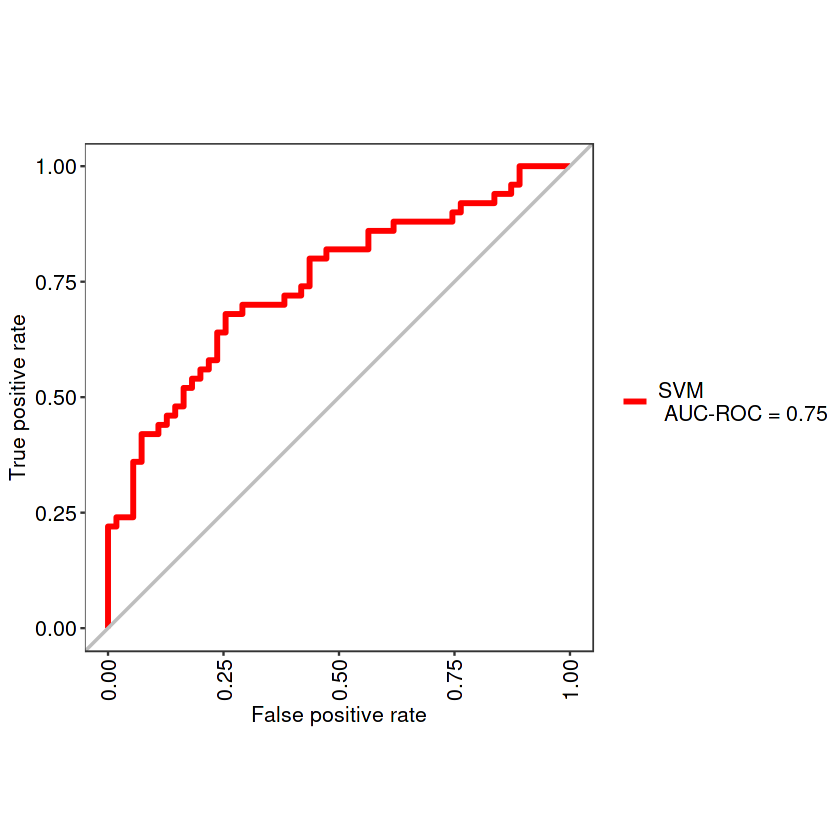

In [11]:
rec = evalm(list(svm_model), gnames = c('SVM'), plots = c("r"), silent = TRUE)

In [12]:
pred = predict(svm_model, otu_held_out)
confusionMatrix(table(task_held_out, pred))

Confusion Matrix and Statistics

             pred
task_held_out Cirrhosis Healthy
    Cirrhosis        12       1
    Healthy           7       5
                                         
               Accuracy : 0.68           
                 95% CI : (0.465, 0.8505)
    No Information Rate : 0.76           
    P-Value [Acc > NIR] : 0.8772         
                                         
                  Kappa : 0.3464         
                                         
 Mcnemar's Test P-Value : 0.0771         
                                         
            Sensitivity : 0.6316         
            Specificity : 0.8333         
         Pos Pred Value : 0.9231         
         Neg Pred Value : 0.4167         
             Prevalence : 0.7600         
         Detection Rate : 0.4800         
   Detection Prevalence : 0.5200         
      Balanced Accuracy : 0.7325         
                                         
       'Positive' Class : Cirrhosis      
             

## Random Forest

Random Forest 

 105 samples
2977 predictors
   2 classes: 'Cirrhosis', 'Healthy' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 84, 84, 84, 84, 84, 84, ... 
Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec     
     2  0.9169697  0.7636364  0.8666667
    77  0.9318182  0.7878788  0.9266667
  2977  0.9345455  0.7878788  0.9266667

ROC was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2977.


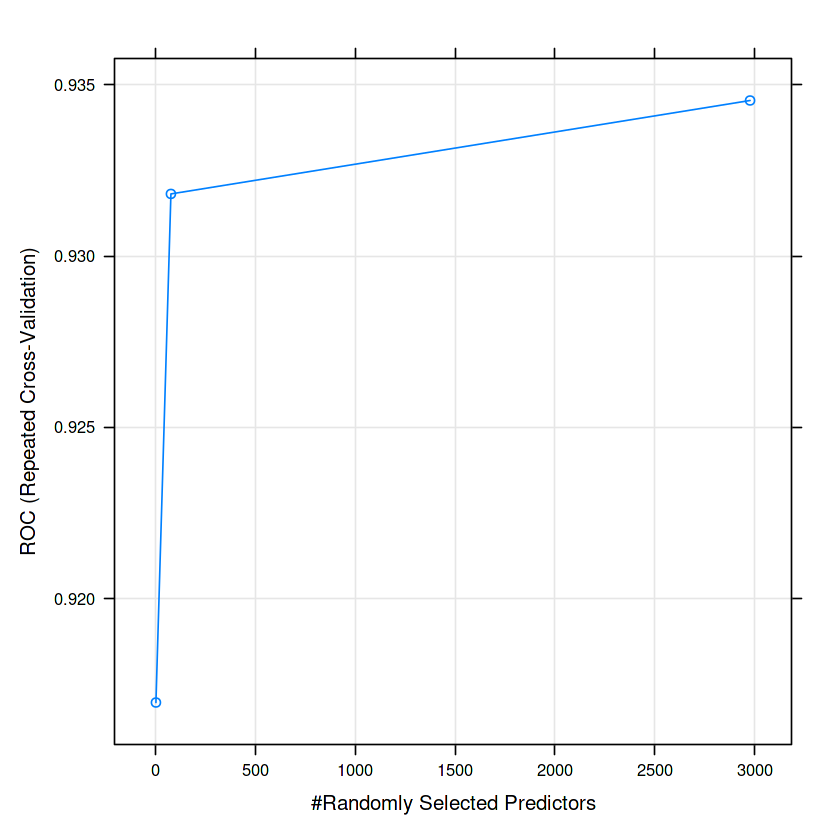

In [13]:
fitControl <- trainControl(method = "repeatedcv", 
                           number = folds,   #number of folds in k-fold CV
                           repeats = nests,  #number of outer repetitions in nested k-fold CV
                           classProbs = TRUE,
                           savePredictions = TRUE,
                           summaryFunction = twoClassSummary)


set.seed(825)
rf_model <- train(x = otu_train, y = task_train_var,
               method = "rf",  
               trControl = fitControl,
               metric = "ROC")

print(rf_model)

plot(rf_model)



In [14]:
rf_model$finalModel$ntree



[1] 500

Random Forest 

 105 samples
2977 predictors
   2 classes: 'Cirrhosis', 'Healthy' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 84, 84, 84, 84, 84, 84, ... 
Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec     
  100   0.9430303  0.8060606  0.9200000
  101   0.9421212  0.8000000  0.9266667
  102   0.9393939  0.7939394  0.9066667
  103   0.9412121  0.8000000  0.9066667
  104   0.9412121  0.7939394  0.9400000
  105   0.9363636  0.7878788  0.9266667
  106   0.9421212  0.7878788  0.9266667
  107   0.9400000  0.7878788  0.9266667
  108   0.9439394  0.7878788  0.9333333
  109   0.9403030  0.8121212  0.9133333
  110   0.9381818  0.7878788  0.9266667
  111   0.9424242  0.8060606  0.9266667
  112   0.9400000  0.8000000  0.9333333
  113   0.9445455  0.8121212  0.9133333
  114   0.9418182  0.8000000  0.9400000
  115   0.9345455  0.7939394  0.9333333

ROC was used to select the optimal model using the largest va

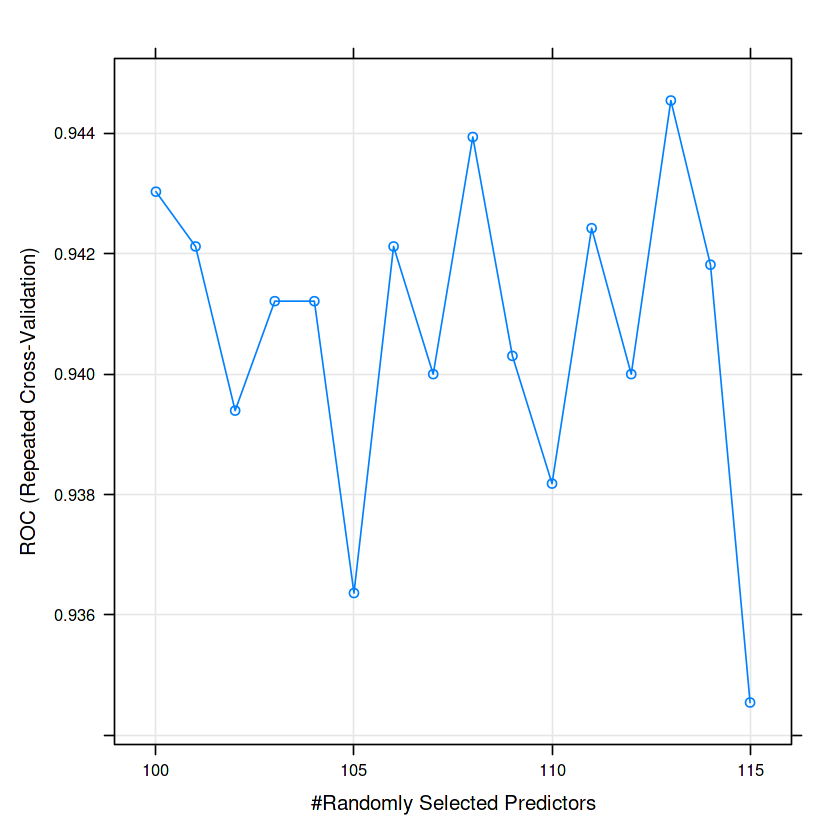

In [15]:
# this might take too much time
fitControl <- trainControl(method = "repeatedcv", 
                           number = folds,   #number of folds in k-fold CV
                           repeats = nests,  #number of outer repetitions in nested k-fold CV
                           classProbs = TRUE,  
                           summaryFunction=twoClassSummary,
                           search='grid',
                           savePredictions = TRUE)

#create tunegrid with 15 values from 100:115 for mtry to tunning model. Our train function will change number of entry variable at each split according to tunegrid. 
tunegrid <- expand.grid(.mtry = (100:115)) 

rf_gridsearch <- train(x = otu_train, y = task_train_var,
               method = "rf", 
               trControl = fitControl, 
               metric = "ROC",
               tuneGrid = tunegrid)

print(rf_gridsearch)

plot(rf_gridsearch)

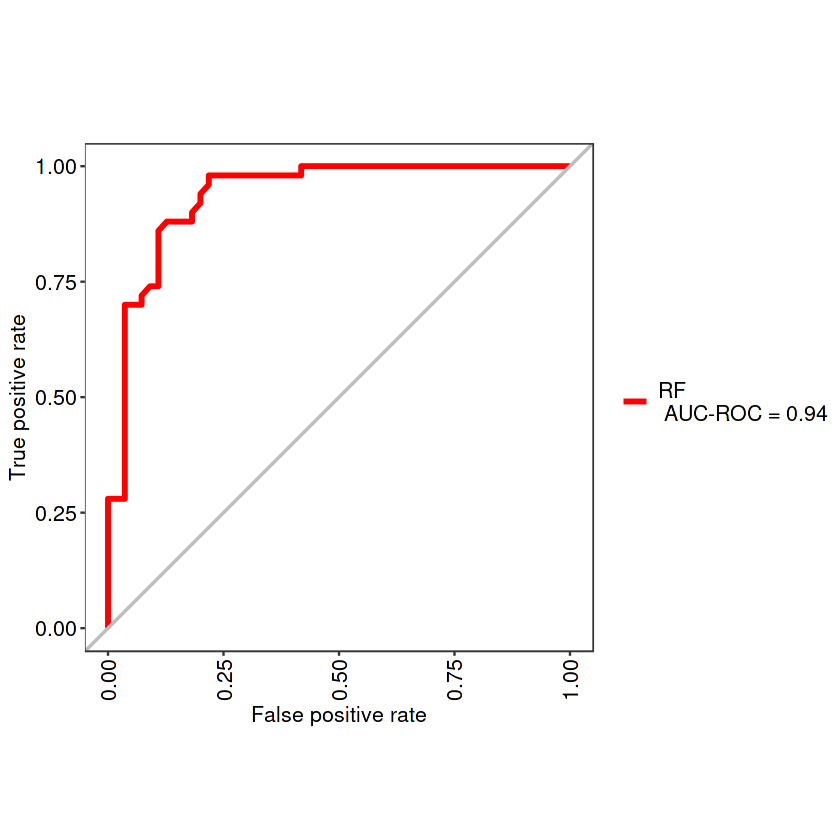

In [16]:
rf_model = rf_gridsearch

rec = evalm(list(rf_model), gnames = c('RF'), plots = c("r"), silent = TRUE)

In [17]:
pred = predict(rf_model, otu_held_out)
confusionMatrix(table(task_held_out, pred))

Confusion Matrix and Statistics

             pred
task_held_out Cirrhosis Healthy
    Cirrhosis        11       2
    Healthy           2      10
                                          
               Accuracy : 0.84            
                 95% CI : (0.6392, 0.9546)
    No Information Rate : 0.52            
    P-Value [Acc > NIR] : 0.0008956       
                                          
                  Kappa : 0.6795          
                                          
 Mcnemar's Test P-Value : 1.0000000       
                                          
            Sensitivity : 0.8462          
            Specificity : 0.8333          
         Pos Pred Value : 0.8462          
         Neg Pred Value : 0.8333          
             Prevalence : 0.5200          
         Detection Rate : 0.4400          
   Detection Prevalence : 0.5200          
      Balanced Accuracy : 0.8397          
                                          
       'Positive' Class : Cirrhosis 

rf variable importance

  only 20 most important variables shown (out of 2977)

                                                                                                                    Overall
NZ_GL538208.1 Megasphaera micronuciformis F0359 Scfld98, whole genome shotgun sequence                               2.1442
NC_013520.1 Veillonella parvula DSM 2008, complete genome                                                            1.1538
NZ_CP007062.1 Fusobacterium nucleatum subsp. animalis 7_1, complete genome                                           1.1423
NZ_KE384564.1 Veillonella montpellierensis DSM 17217 K357DRAFT_scaffold00008.8, whole genome shotgun sequence        0.9771
NZ_GL732439.1 Streptococcus infantis ATCC 700779 genomic scaffold SCAFFOLD1, whole genome shotgun sequence           0.9158
NZ_KE384565.1 Veillonella montpellierensis DSM 17217 K357DRAFT_scaffold00019.19, whole genome shotgun sequence       0.8857
NC_007929.1 Lactobacillus salivarius UCC118 chromoso

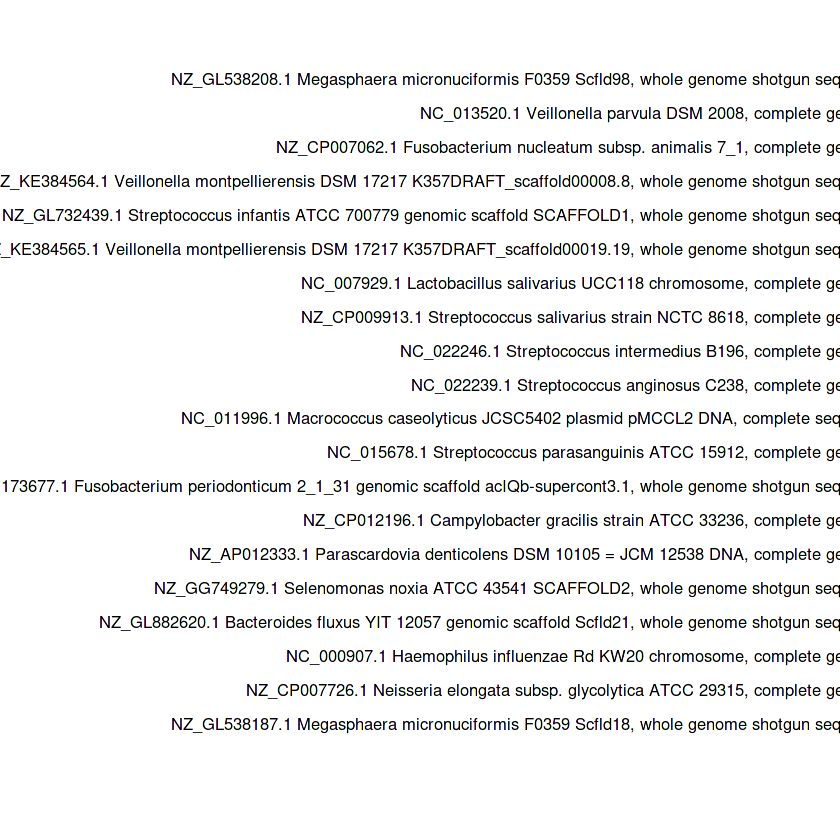

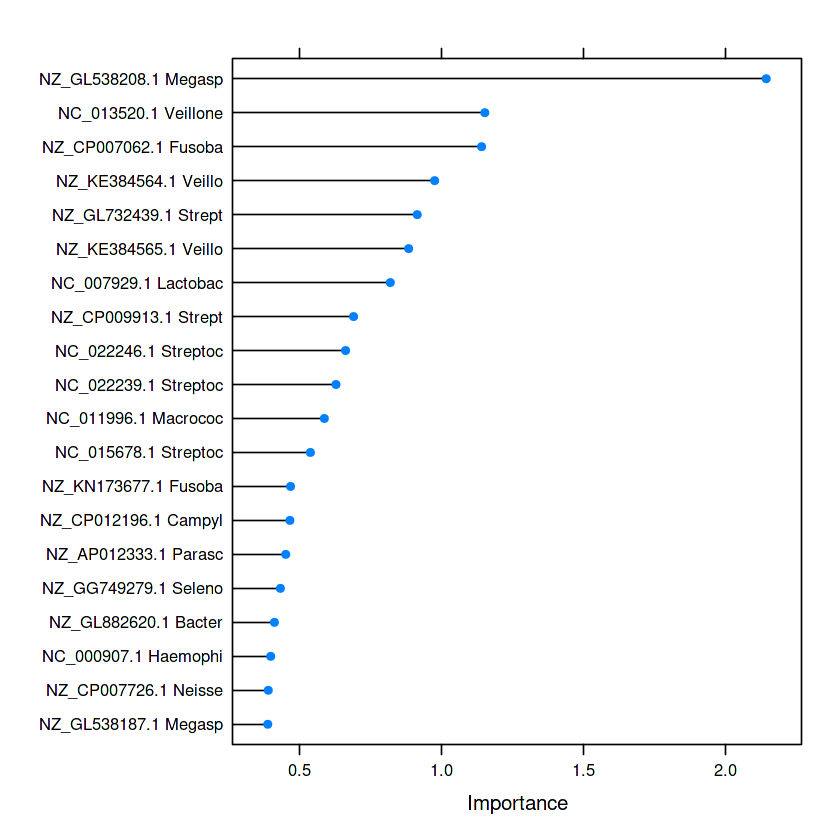

In [18]:
V = varImp(rf_model, scale = FALSE)

print(V)

plot(V, top = 20)

#shorten row names 
tmp = row.names(V$importance)
tmp = substring(tmp, first = 1, last = 20)
row.names(V$importance) = tmp

plot( V, 20)

## Model Comparison

In [19]:
resamps <- resamples(list(LogReg = regLog_model,
                          SVM = svm_model,
                          RF = rf_model))
resamps

summary(resamps)


Call:
resamples.default(x = list(LogReg = regLog_model, SVM = svm_model, RF
 = rf_model))

Models: LogReg, SVM, RF 
Number of resamples: 15 
Performance metrics: ROC, Sens, Spec 
Time estimates for: everything, final model fit 


Call:
summary.resamples(object = resamps)

Models: LogReg, SVM, RF 
Number of resamples: 15 

ROC 
            Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
LogReg 0.4000000 0.5727273 0.7272727 0.6606061 0.7500000 0.8363636    0
SVM    0.6227273 0.6863636 0.7545455 0.7554545 0.8136364 0.9000000    0
RF     0.8818182 0.9227273 0.9363636 0.9445455 0.9750000 1.0000000    0

Sens 
            Min.   1st Qu.    Median      Mean   3rd Qu. Max. NA's
LogReg 0.5454545 0.7727273 0.8181818 0.8424242 0.9545455    1    0
SVM    0.8181818 0.9090909 1.0000000 0.9454545 1.0000000    1    0
RF     0.6363636 0.7272727 0.8181818 0.8121212 0.9090909    1    0

Spec 
       Min. 1st Qu. Median      Mean 3rd Qu. Max. NA's
LogReg  0.0     0.2    0.3 0.3333333     0.5  0.7    0
SVM     0.1     0.2    0.3 0.3066667     0.4  0.7    0
RF      0.8     0.9    0.9 0.9133333     1.0  1.0    0


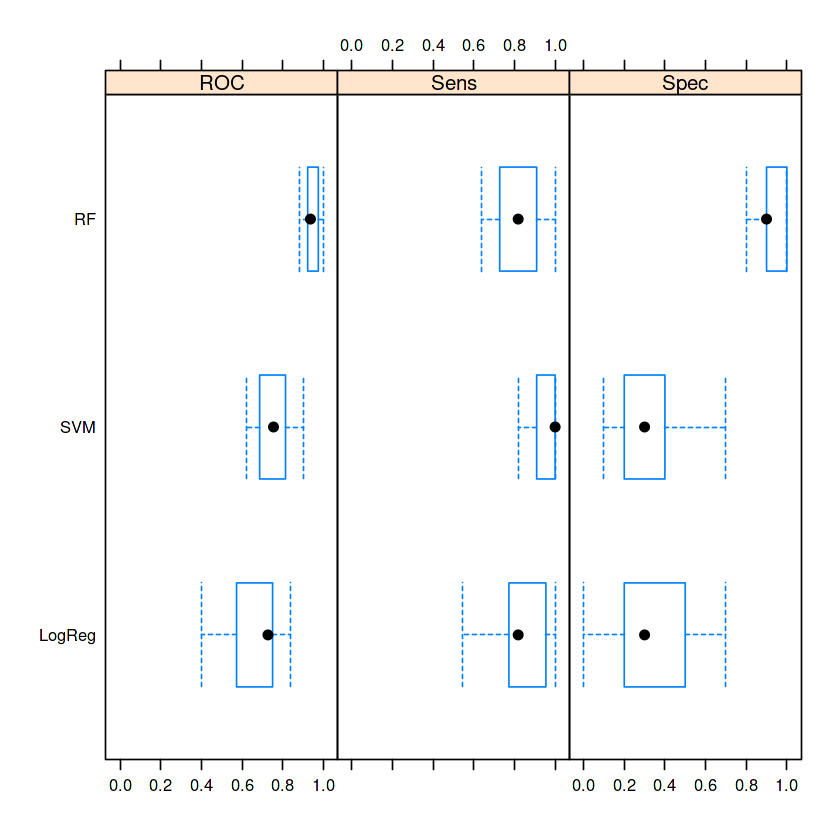

In [20]:
theme1 <- trellis.par.get()
theme1$plot.symbol$col = rgb(.2, .2, .2, .4)
theme1$plot.symbol$pch = 16
theme1$plot.line$col = rgb(1, 0, 0, .7)
theme1$plot.line$lwd <- 2
trellis.par.set(theme1)
bwplot(resamps, layout = c(3, 1))



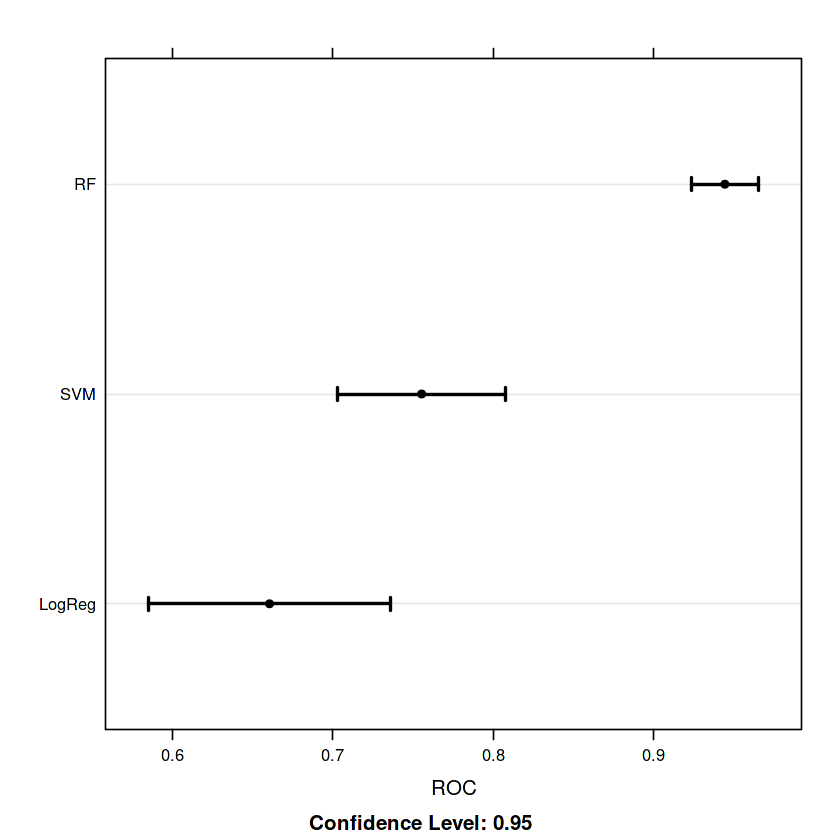

In [21]:
trellis.par.set(caretTheme())
dotplot(resamps, metric = "ROC")

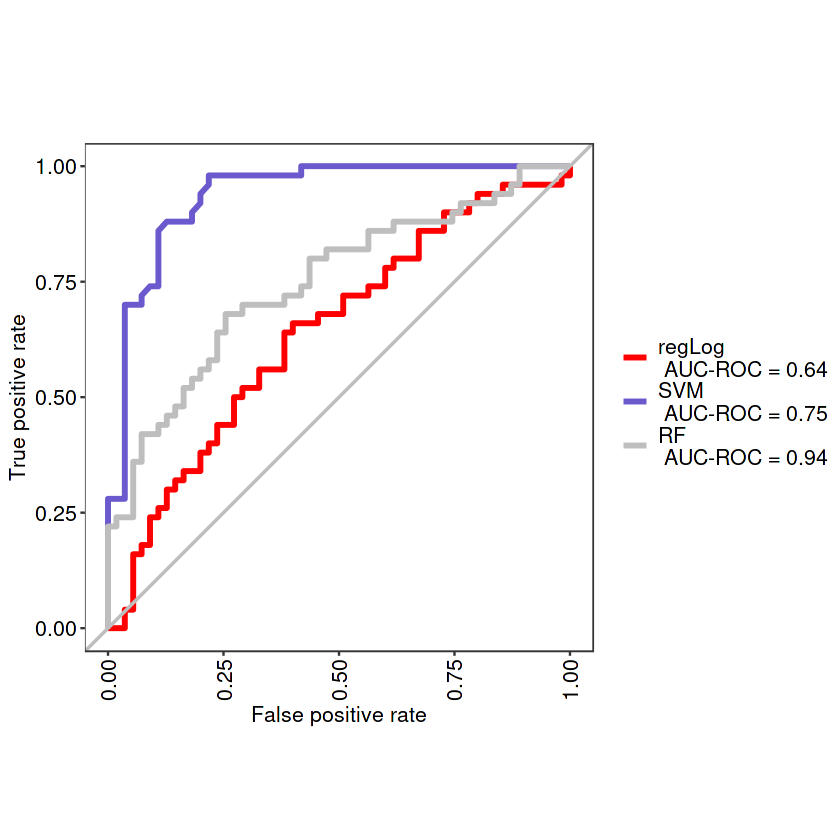

In [22]:
res <- evalm(list(regLog_model, svm_model, rf_model),
             gnames = c('regLog','SVM','RF'), 
             plots = c("r") , 
             silent = TRUE )

## ALDEx2: ANOVA-Like DE tool for compositional data
- We can check the overlap of our ML results on top features with the DE features from this step

In [23]:
require(ALDEx2)

otu_table_file = "/kaggle/input/cirrhosis/otutable.txt"

#read data table
otu_DF = read.table(otu_table_file, sep="\t", comment="", row=1, head=T, check.names=F, quote="")

#read the file with information on predictors
task = read.table(task_file, sep="\t", comment="", row=1, head=T, quote="", check.names=F, colClasses="character")

#Generate Monte Carlo samples of the Dirichlet distribution for each sample and normalize the sample with centred log-ratio transform 
x = aldex.clr(otu_DF, task$Var, mc.samples=128, denom="all")

#find the most significant features
ttest_test = aldex.ttest(x)

operating in serial mode

computing center with all features



In [24]:
head(ttest_test,10)

ttest_test_sortedBH = ttest_test[order(ttest_test$wi.eBH), ]

head(ttest_test_sortedBH,10)

write.table(ttest_test_sortedBH,'qun2014_ttest.txt', quote = FALSE, row.names = TRUE, col.names = NA, sep = '\t')

,we.ep,we.eBH,wi.ep,wi.eBH
,<dbl>,<dbl>,<dbl>,<dbl>
"NC_012781.1 Eubacterium rectale ATCC 33656, complete genome",1.517606e-03,1.876018e-02,2.121570e-03,2.314837e-02
"NC_006347.1 Bacteroides fragilis YCH46 DNA, complete genome",1.266351e-01,3.728406e-01,3.410584e-01,6.246588e-01
"NC_004663.1 Bacteroides thetaiotaomicron VPI-5482 chromosome, complete genome",2.271696e-01,5.156512e-01,1.716016e-01,4.339647e-01
"NC_004337.2 Shigella flexneri 2a str. 301 chromosome, complete genome",2.786392e-01,5.669852e-01,5.229612e-02,2.115977e-01
"NC_002695.1 Escherichia coli O157:H7 str. Sakai, complete genome",5.802362e-01,8.059534e-01,1.369403e-01,3.809291e-01
"NC_000913.3 Escherichia coli str. K-12 substr. MG1655, complete genome",2.082779e-01,4.920531e-01,5.664272e-02,2.227914e-01
"NC_000907.1 Haemophilus influenzae Rd KW20 chromosome, complete genome",2.692712e-09,4.802203e-07,4.999881e-10,1.457846e-07
"NC_000896.1 Lactobacillus prophage phiadh, complete genome",2.480735e-01,4.304109e-01,2.742040e-01,4.525196e-01
"NC_000872.1 Streptococcus phage Sfi21, complete genome",4.095036e-01,6.159200e-01,3.717663e-01,5.683978e-01


,we.ep,we.eBH,wi.ep,wi.eBH
,<dbl>,<dbl>,<dbl>,<dbl>
"NZ_GL538208.1 Megasphaera micronuciformis F0359 Scfld98, whole genome shotgun sequence",1.398676e-12,7.270353e-10,1.729287e-13,5.983059e-10
"NC_013520.1 Veillonella parvula DSM 2008, complete genome",1.219757e-17,1.023356e-13,1.974149e-13,6.970446e-10
"NZ_CP007062.1 Fusobacterium nucleatum subsp. animalis 7_1, complete genome",5.850247e-11,1.326701e-08,1.122028e-12,1.887366e-09
"NC_022239.1 Streptococcus anginosus C238, complete genome",1.902623e-11,7.986296e-09,8.349806e-12,7.711578e-09
"NZ_GL538194.1 Megasphaera micronuciformis F0359 Scfld29, whole genome shotgun sequence",2.278403e-09,2.389030e-07,1.656214e-11,7.952344e-09
"NZ_GL538184.1 Megasphaera micronuciformis F0359 Scfld14, whole genome shotgun sequence",1.768581e-10,3.698845e-08,1.398237e-11,8.712503e-09
"NZ_GL538181.1 Megasphaera micronuciformis F0359 Scfld11, whole genome shotgun sequence",1.395651e-10,3.477287e-08,2.386122e-11,1.152522e-08
"NC_007929.1 Lactobacillus salivarius UCC118 chromosome, complete genome",1.131888e-11,5.233442e-09,1.545884e-11,1.152836e-08
"NZ_GL538185.1 Megasphaera micronuciformis F0359 Scfld15, whole genome shotgun sequence",1.745747e-09,2.264070e-07,1.073683e-10,3.701934e-08


In [25]:
#let's check how many features are statistically significant assuming alpha = 0.01
sum(ttest_test_sortedBH[, c("wi.eBH")] < 0.01)

[1] 477

In [26]:
aldex_top500 = row.names(ttest_test_sortedBH)[1:500]

aldex_top500[1:10]

[1] "NZ_GL538208.1 Megasphaera micronuciformis F0359 Scfld98, whole genome shotgun sequence"
 [2] "NC_013520.1 Veillonella parvula DSM 2008, complete genome"                             
 [3] "NZ_CP007062.1 Fusobacterium nucleatum subsp. animalis 7_1, complete genome"            
 [4] "NC_022239.1 Streptococcus anginosus C238, complete genome"                             
 [5] "NZ_GL538194.1 Megasphaera micronuciformis F0359 Scfld29, whole genome shotgun sequence"
 [6] "NZ_GL538184.1 Megasphaera micronuciformis F0359 Scfld14, whole genome shotgun sequence"
 [7] "NZ_GL538181.1 Megasphaera micronuciformis F0359 Scfld11, whole genome shotgun sequence"
 [8] "NC_007929.1 Lactobacillus salivarius UCC118 chromosome, complete genome"               
 [9] "NZ_GL538185.1 Megasphaera micronuciformis F0359 Scfld15, whole genome shotgun sequence"
[10] "NZ_CP007726.1 Neisseria elongata subsp. glycolytica ATCC 29315, complete genome"

In [27]:
V = varImp(rf_model)

#get the table with importance values for features and sort it in decreasing order 
tmp2 = V$importance
tmp2 = tmp2[order(tmp2$Overall, decreasing = TRUE),,drop=FALSE]

#tget the name of the 500 most important features according to RF model
rf_top500 = row.names(tmp2)[1:500]

#check how many of features from RF top 500 overlaps with the features that were assessed 
#as significant by statiscal analysis
overlap = intersect(aldex_top500,rf_top500)

#check how many features overlap
length(overlap)

#print overlapping features 
print(overlap)


[1] 210

  [1] "NZ_GL538208.1 Megasphaera micronuciformis F0359 Scfld98, whole genome shotgun sequence"                                                        
  [2] "NC_013520.1 Veillonella parvula DSM 2008, complete genome"                                                                                     
  [3] "NZ_CP007062.1 Fusobacterium nucleatum subsp. animalis 7_1, complete genome"                                                                    
  [4] "NC_022239.1 Streptococcus anginosus C238, complete genome"                                                                                     
  [5] "NC_007929.1 Lactobacillus salivarius UCC118 chromosome, complete genome"                                                                       
  [6] "NZ_CP007726.1 Neisseria elongata subsp. glycolytica ATCC 29315, complete genome"                                                               
  [7] "NZ_KE384565.1 Veillonella montpellierensis DSM 17217 K357DRAFT_scaffold00019.19, whole 